In [10]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import tensorflow as tf
import random
from PIL import Image, ImageFile
import seaborn as sns
from termcolor import colored
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files

# Tensorflow Libraries
from tensorflow.keras import layers, models, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.layers import Dense, Dropout, Layer, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.applications import MobileNetV2, Xception, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import plot_model, to_categorical

# System libraries
from pathlib import Path
import os.path

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("niten19/face-shape-dataset")

print("Path to dataset files:", path)

100%|██████████| 639M/639M [00:34<00:00, 19.2MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2


In [3]:
DATA_DIR = os.path.join(path, 'FaceShape Dataset')

In [4]:
TRAIN_DIR = os.path.join(DATA_DIR , 'training_set')
TEST_DIR = os.path.join(DATA_DIR , 'testing_set')

In [5]:
print(os.listdir(TRAIN_DIR))

['Oblong', 'Heart', 'Oval', 'Round', 'desktop.ini', 'Square']


In [6]:
VAL_DIR = os.path.join(DATA_DIR, 'validation_set')

if not os.path.exists(VAL_DIR):
    os.makedirs(VAL_DIR)

print(f"validation_set directory successully made in : {VAL_DIR}")

validation_set directory successully made in : /root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/validation_set


In [7]:
from os.path import join

img_folders = [join(TRAIN_DIR, folder) for folder in os.listdir(TRAIN_DIR)]
list(img_folders)

['/root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/training_set/Oblong',
 '/root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/training_set/Heart',
 '/root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/training_set/Oval',
 '/root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/training_set/Round',
 '/root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/training_set/desktop.ini',
 '/root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/training_set/Square']

In [8]:
#Utils

def split_data_for_validation(train_dir, val_dir, split_ratio=0.1):
    """
    Membagi data dari train_dir ke val_dir dengan split_ratio secara seimbang berdasarkan label.

    Args:
        train_dir (str): Path ke direktori data training.
        val_dir (str): Path ke direktori data validation.
        split_ratio (float): Rasio data yang akan dipindahkan ke validation.
    """
    # Membuat direktori val_dir jika belum ada
    if not os.path.exists(val_dir):
        os.makedirs(val_dir)

    # Mendapatkan daftar subdirektori (label) dalam train_dir
    labels = [label for label in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, label))]

    for label in labels:
        label_train_path = os.path.join(train_dir, label)
        label_val_path = os.path.join(val_dir, label)

        # Membuat folder label di val_dir jika belum ada
        if not os.path.exists(label_val_path):
            os.makedirs(label_val_path)

        # Mendapatkan daftar file dalam subdirektori label
        files = [f for f in os.listdir(label_train_path) if os.path.isfile(os.path.join(label_train_path, f))]

        # Mengacak file dan memilih 10% untuk validation
        random.shuffle(files)
        split_count = int(len(files) * split_ratio)
        val_files = files[:split_count]

        # Memindahkan file ke direktori val_dir
        for file in val_files:
            src_path = os.path.join(label_train_path, file)
            dest_path = os.path.join(label_val_path, file)
            shutil.move(src_path, dest_path)

        print(f"{len(val_files)} files moved from {label_train_path} to {label_val_path}")


def plot_data_distribution(train_dir, val_dir, test_dir):
    # Membuat daftar direktori dan label
    dirs = {"Train": train_dir, "Validation": val_dir, "Test": test_dir}
    data = []

    for dataset_type, dir_path in dirs.items():
        classes = [class_name for class_name in os.listdir(dir_path) if class_name != 'desktop.ini']
        for class_name in classes:
            class_path = os.path.join(dir_path, class_name)
            count = len(os.listdir(class_path))
            data.append({"Dataset": dataset_type, "Label": class_name, "Count": count})

    # Mengubah data menjadi dataframe
    import pandas as pd
    df = pd.DataFrame(data)

    # Membuat plot
    plt.figure(figsize=(14, 7))
    palette = sns.color_palette("pastel", len(df['Label'].unique()))
    ax = sns.barplot(data=df, x="Label", y="Count", hue="Dataset", palette=palette)

    # Rotasi label x-axis
    plt.xticks(rotation=45, ha='right', fontsize=12)

    # Menambahkan label jumlah di atas bar
    for container in ax.containers:
        ax.bar_label(container, fontsize=10, fmt='%d', padding=3)

    # Menambahkan grid horizontal
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Menambahkan judul dan label sumbu
    plt.title('Data Composition Across Train, Validation, and Test Sets', fontsize=18, fontweight='bold')
    plt.xlabel('Labels', fontsize=14)
    plt.ylabel('Counts', fontsize=14)

    plt.tight_layout()
    plt.legend(title="Dataset", fontsize=12)
    plt.show()


def create_df(folder_path) :
    classes = [class_name for class_name in os.listdir(folder_path) if class_name != 'desktop.ini']

    all_images = []
    for class_name in classes:
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name)
                           for file_name in os.listdir(class_path)])

    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [11]:
split_data_for_validation(TRAIN_DIR, VAL_DIR)

80 files moved from /root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/training_set/Oblong to /root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/validation_set/Oblong
80 files moved from /root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/training_set/Heart to /root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/validation_set/Heart
80 files moved from /root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/training_set/Oval to /root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/validation_set/Oval
80 files moved from /root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/training_set/Round to /root/.cache/kagglehub/datasets/niten19/face-shape-dataset/versions/2/FaceShape Dataset/validation_set/Round
80 files moved from /root/.cache/kagglehub/d

<ipython-input-8-03b37d1e64ad>:63: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax = sns.barplot(data=df, x="Label", y="Count", hue="Dataset", palette=palette)


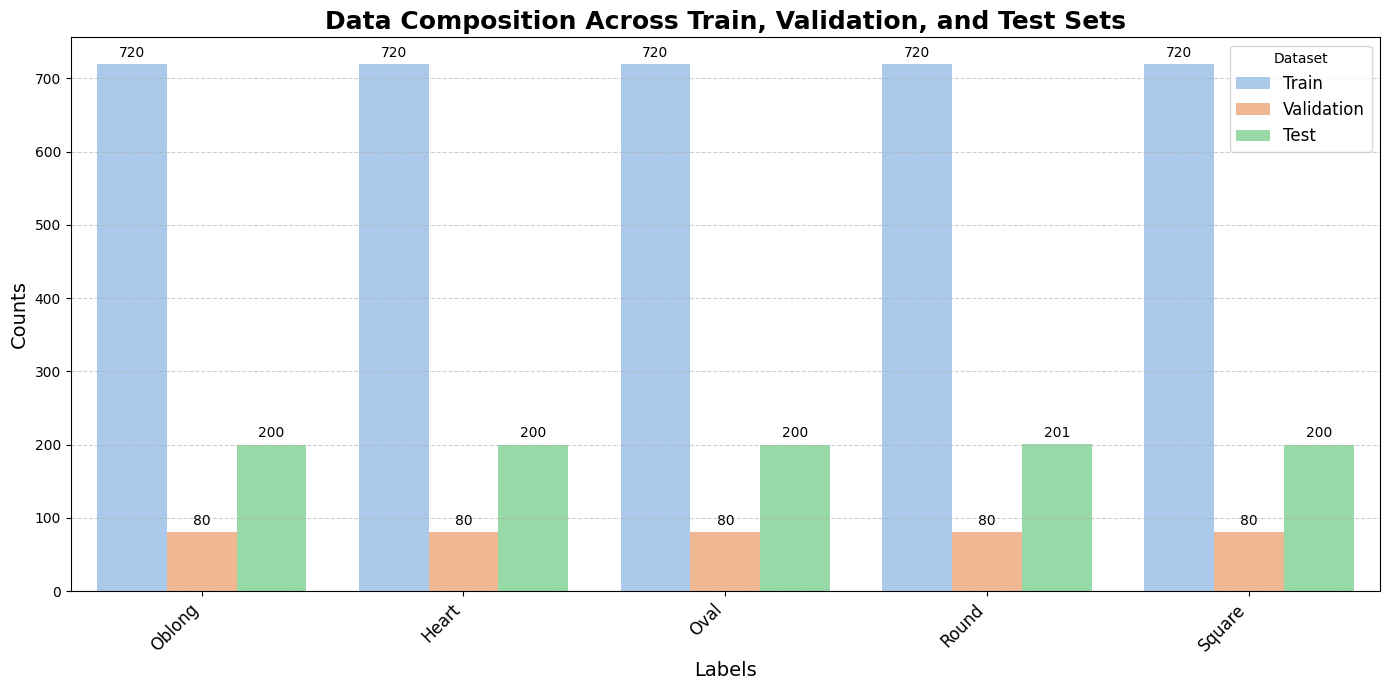

In [12]:
plot_data_distribution(TRAIN_DIR, VAL_DIR, TEST_DIR)

In [13]:
train_df = create_df(TRAIN_DIR)
val_df = create_df(VAL_DIR)
test_df = create_df(TEST_DIR)

In [14]:
print(train_df)

                                              file_path   label
0     /root/.cache/kagglehub/datasets/niten19/face-s...  Oblong
1     /root/.cache/kagglehub/datasets/niten19/face-s...  Oblong
2     /root/.cache/kagglehub/datasets/niten19/face-s...  Oblong
3     /root/.cache/kagglehub/datasets/niten19/face-s...  Oblong
4     /root/.cache/kagglehub/datasets/niten19/face-s...  Oblong
...                                                 ...     ...
3595  /root/.cache/kagglehub/datasets/niten19/face-s...  Square
3596  /root/.cache/kagglehub/datasets/niten19/face-s...  Square
3597  /root/.cache/kagglehub/datasets/niten19/face-s...  Square
3598  /root/.cache/kagglehub/datasets/niten19/face-s...  Square
3599  /root/.cache/kagglehub/datasets/niten19/face-s...  Square

[3600 rows x 2 columns]


In [15]:
print(val_df)

                                             file_path   label
0    /root/.cache/kagglehub/datasets/niten19/face-s...  Oblong
1    /root/.cache/kagglehub/datasets/niten19/face-s...  Oblong
2    /root/.cache/kagglehub/datasets/niten19/face-s...  Oblong
3    /root/.cache/kagglehub/datasets/niten19/face-s...  Oblong
4    /root/.cache/kagglehub/datasets/niten19/face-s...  Oblong
..                                                 ...     ...
395  /root/.cache/kagglehub/datasets/niten19/face-s...  Square
396  /root/.cache/kagglehub/datasets/niten19/face-s...  Square
397  /root/.cache/kagglehub/datasets/niten19/face-s...  Square
398  /root/.cache/kagglehub/datasets/niten19/face-s...  Square
399  /root/.cache/kagglehub/datasets/niten19/face-s...  Square

[400 rows x 2 columns]


In [16]:
print(test_df)

                                              file_path   label
0     /root/.cache/kagglehub/datasets/niten19/face-s...  Oblong
1     /root/.cache/kagglehub/datasets/niten19/face-s...  Oblong
2     /root/.cache/kagglehub/datasets/niten19/face-s...  Oblong
3     /root/.cache/kagglehub/datasets/niten19/face-s...  Oblong
4     /root/.cache/kagglehub/datasets/niten19/face-s...  Oblong
...                                                 ...     ...
996   /root/.cache/kagglehub/datasets/niten19/face-s...  Square
997   /root/.cache/kagglehub/datasets/niten19/face-s...  Square
998   /root/.cache/kagglehub/datasets/niten19/face-s...  Square
999   /root/.cache/kagglehub/datasets/niten19/face-s...  Square
1000  /root/.cache/kagglehub/datasets/niten19/face-s...  Square

[1001 rows x 2 columns]


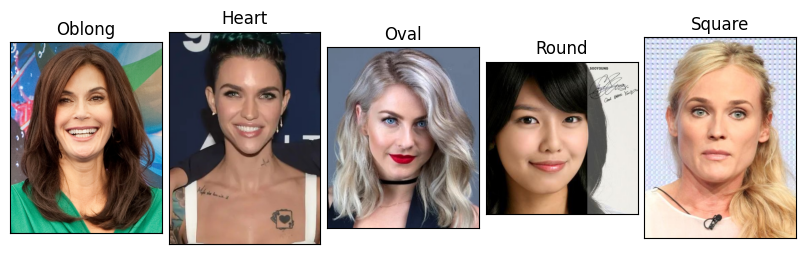

In [17]:
# Create a DataFrame with one Label of each category
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Display some pictures of the dataset
fig, axes = plt.subplots(ncols=5, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [27]:
#Hyperparameters
image_size = (224, 224)
batch_size = 32
seed = 42

In [28]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
    seed=seed
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='file_path',
    y_col='label',
    target_size=image_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
    seed=seed
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 3600 validated image filenames belonging to 5 classes.
Found 400 validated image filenames belonging to 5 classes.
Found 1000 validated image filenames belonging to 5 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="file_path". These filename(s) will be ignored.
  warnings.warn(


In [29]:
display(train_generator.class_indices)
display(val_generator.class_indices)
display(test_generator.class_indices)

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}

{'Heart': 0, 'Oblong': 1, 'Oval': 2, 'Round': 3, 'Square': 4}

In [30]:
# print('Loading Xception ...')
# base_model = Xception(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet'
# )
# print('Xception loaded')

# print('Loading MobileNetV2 ...')
# base_model = MobileNetV2(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet',
# )
# print('MobileNetV2 loaded')

print('Loading ResNet50 ...')
base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)
print('ResNet50 loaded')

Loading ResNet50 ...
ResNet50 loaded


In [31]:
# Name of layers in Xception
for layer in base_model.layers :
    print(layer.name)

input_layer_1
conv1_pad
conv1_conv
conv1_bn
conv1_relu
pool1_pad
pool1_pool
conv2_block1_1_conv
conv2_block1_1_bn
conv2_block1_1_relu
conv2_block1_2_conv
conv2_block1_2_bn
conv2_block1_2_relu
conv2_block1_0_conv
conv2_block1_3_conv
conv2_block1_0_bn
conv2_block1_3_bn
conv2_block1_add
conv2_block1_out
conv2_block2_1_conv
conv2_block2_1_bn
conv2_block2_1_relu
conv2_block2_2_conv
conv2_block2_2_bn
conv2_block2_2_relu
conv2_block2_3_conv
conv2_block2_3_bn
conv2_block2_add
conv2_block2_out
conv2_block3_1_conv
conv2_block3_1_bn
conv2_block3_1_relu
conv2_block3_2_conv
conv2_block3_2_bn
conv2_block3_2_relu
conv2_block3_3_conv
conv2_block3_3_bn
conv2_block3_add
conv2_block3_out
conv3_block1_1_conv
conv3_block1_1_bn
conv3_block1_1_relu
conv3_block1_2_conv
conv3_block1_2_bn
conv3_block1_2_relu
conv3_block1_0_conv
conv3_block1_3_conv
conv3_block1_0_bn
conv3_block1_3_bn
conv3_block1_add
conv3_block1_out
conv3_block2_1_conv
conv3_block2_1_bn
conv3_block2_1_relu
conv3_block2_2_conv
conv3_block2_2_bn


In [32]:
base_model.trainable = True

set_trainable = False

for layer in base_model.layers :
    if layer.name == 'conv5_block3_1_conv' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

In [33]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,850,629 (90.98 MB)

 Trainable params: 4,728,581 (18.04 MB)

 Non-trainable params: 19,122,048 (72.94 MB)

In [34]:
# Optimizer
# opt = RMSprop(learning_rate=0.001, rho=0.9, epsilon=1e-08)
opt = Adam(learning_rate=0.00001)
# opt = SGD(learning_rate=0.001, momentum=0.9)

# Compilation
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Model CheckPoint
checkpoint_cb = ModelCheckpoint('BestModel.keras', save_best_only=True)

# Early Stoping
earlystop_cb = EarlyStopping(patience=10, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-7)

In [ ]:
epochs_0 = 50

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=epochs_0,
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


113/113 ━━━━━━━━━━━━━━━━━━━━ 90s 644ms/step - accuracy: 0.2061 - loss: 2.1186 - val_accuracy: 0.2300 - val_loss: 1.6588 - learning_rate: 1.0000e-05
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 536ms/step - accuracy: 0.2293 - loss: 1.8505 - val_accuracy: 0.2600 - val_loss: 1.5909 - learning_rate: 1.0000e-05
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 63s 531ms/step - accuracy: 0.2476 - loss: 1.7283 - val_accuracy: 0.3100 - val_loss: 1.5445 - learning_rate: 1.0000e-05
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 549ms/step - accuracy: 0.2861 - loss: 1.6490 - val_accuracy: 0.3250 - val_loss: 1.5177 - learning_rate: 1.0000e-05
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 82s 553ms/step - accuracy: 0.3049 - loss: 1.5816 - val_accuracy: 0.3400 - val_loss: 1.4959 - learning_rate: 1.0000e-05
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 79s 534ms/step - accuracy: 0.3362 - loss: 1.5258 - val_accuracy: 0.3575 - val_loss: 1.4779 - learning_rate: 1.0000e-05
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 64s 534ms/step - 

In [ ]:
model.save('MyModel.keras')

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

import matplotlib.pyplot as plt


epochs = range(len(acc))
plt.plot(epochs,acc,'bo',label='Training acc')
plt.plot(epochs,val_acc,'r',label='Validation acc')
plt.legend()


plt.figure()
plt.plot(epochs,loss,'bo',label='Training loss')
plt.plot(epochs,val_loss,'r',label='Validation loss')

plt.legend()
plt.show()

In [ ]:
y_pred = model.predict(test_generator)
cm = confusion_matrix(test_generator.classes, np.argmax(y_pred, axis=1))

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=test_generator.class_indices, yticklabels=test_generator.class_indices)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()